###**Import Libraries**

In [1]:
from google.colab import files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold,cross_val_score,KFold,StratifiedKFold
from sklearn.metrics import accuracy_score,f1_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [2]:
from sklearn.metrics import confusion_matrix
def plot_conf_matrix(y_test,y_pred,uniqueclassLabel, title="CMatrix"):
  cm = confusion_matrix(y_true=y_test,y_pred=y_pred,labels=uniqueclassLabel)
  plt.figure(figsize=(5,4))
  plt.title(title)
  #ax = plt.subplot()
  sns.heatmap(cm, annot=True,cmap='Blues',
              yticklabels=uniqueclassLabel,xticklabels=uniqueclassLabel,fmt='3g')

In [3]:
rand_state=42
k_fold = 5

###**Import Utility File**

In [4]:
# import sys
# path = "/content/drive/MyDrive/Colab Notebooks/Project_Dissertation"
# sys.path.insert(0,path + "/Code")
# import morningStarUtilities

In [5]:
user = 'nishitgala89'
repo = 'ProjectDissertation'
src_dir = "Code/utilities"
pyfile = "morningStarUtilities.py"

url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{src_dir}/{pyfile}"
!wget --no-cache --backups=1 {url}

--2022-01-09 01:23:26--  https://raw.githubusercontent.com/nishitgala89/ProjectDissertation/main/Code/utilities/morningStarUtilities.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6484 (6.3K) [text/plain]
Failed to rename morningStarUtilities.py to morningStarUtilities.py.1: (2) No such file or directory
Saving to: ‘morningStarUtilities.py’

morningStarUtilitie 100%[===================>]   6.33K  --.-KB/s    in 0s      

2022-01-09 01:23:27 (56.5 MB/s) - ‘morningStarUtilities.py’ saved [6484/6484]



In [6]:
# import subprocess

# result = subprocess.run(["wget", "--no-cache", "--backups=1", url], stderr=subprocess.PIPE, stdout=subprocess.PIPE)
# print(result.stderr.decode("utf-8"))

import morningStarUtilities

### **Import Training Data**

In [7]:
train_df = pd.read_csv("https://raw.githubusercontent.com/nishitgala89/ProjectDissertation/main/Datasheets/3_Modelling/morningstar_removedDuplicates_train_withoutLogTransform_withoutM60.csv").set_index("SecId")

### **Import Testing Data**

In [8]:
test_df = pd.read_csv('https://raw.githubusercontent.com/nishitgala89/ProjectDissertation/main/Datasheets/3_Modelling/morningstar_removedDuplicates_test_withoutLogTransform_withoutM60.csv').set_index("SecId")

In [9]:
train_df.shape, test_df.shape

((886, 34), (296, 34))

### **Import Unseen Data (Asia Developed Geography) for Model Generalization check**

In [10]:
asia_df = pd.read_csv('https://raw.githubusercontent.com/nishitgala89/ProjectDissertation/main/Datasheets/3_Modelling/Generalization_Check_Asia_Developed.csv').set_index("SecId")
asia_df = morningStarUtilities.createSize_InvestmentTypeFeature(asia_df)

In [11]:
asia_df[asia_df.FundTNAV.isnull()]

,Name,StarRatingM255,SustainabilityRank,CategoryName,Yield_M12,GBRReturnW1,GBRReturnM1,GBRReturnM3,GBRReturnM6,GBRReturnM0,GBRReturnM12,GBRReturnM36,GBRReturnM60,MaxFrontEndLoad,OngoingCostActual,TransactionFeeActual,ManagerTenure,FundTNAV,EquityStyleBox,AverageMarketCapital,MorningstarRiskM255,AlphaM36,BetaM36,R2M36,StandardDeviationM36,SharpeM36,ReturnProfilePreservation,ReturnProfileIncome,ReturnProfileHedging,TrackRecordExtension,Size,Style
SecId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
F00001071Q,BIEF Emerging Markets A GBP Acc,4,2,Global Emerging Markets Equity,0.62047,1.43,1.64,-3.35,-7.72,0.09,10.79,10.05,NaN,NaN,1.12,1.17,24.08,NaN,2,28614.24791,4,2.47,1.02,89.7,16.24,0.66,3,1,3.0,False,1,2


In [12]:
asia_df.drop(index='F00001071Q',inplace=True)

### **Creating runtime variables**

In [13]:
unique_class_label = list(train_df.StarRatingM255.unique())
unique_class_label.sort()
unique_class_label

[1, 2, 3, 4, 5]

In [14]:
cv_val_accuracy = []
cv_test_accuracy = []
cv_val_f1 = []
cv_test_f1 = []

In [15]:
cv_val_acc_mean = []
cv_test_acc_mean = []
# cv_std = []
# cv_bal_mean = []
# cv_bal_std = []
cv_val_f1_w_mean = []
cv_test_f1_w_mean = []

### **Defining Classifiers**

In [16]:
# !pip install catboost

In [17]:
# from catboost import CatBoostClassifier
clfs = []
clfs.append(RandomForestClassifier(n_estimators=350,max_depth=8, max_features=0.64,
                                    random_state=rand_state, criterion="entropy"))
clfs.append(XGBClassifier(n_estimators=250, max_depth=10, random_state=rand_state,verbose=1,learning_rate=0.001,
                           verbosity=1,booster='dart', normalize_type='forest', rate_drop = 0.3, subsample = 0.4,
                           objective='multi:softprob'))
clfs.append(BaggingClassifier(base_estimator=LogisticRegression(max_iter=5000, random_state=rand_state),bootstrap_features=False,
                              max_features=0.7,max_samples=0.6, n_estimators=250, n_jobs=-1))
clfs.append(LogisticRegression(max_iter=1000,random_state=rand_state ))
clfs.append(GradientBoostingClassifier(n_estimators= 400,random_state=rand_state,learning_rate=0.005, max_features = 0.64, min_samples_split=10, min_samples_leaf=25))
len(clfs)

5

#### Weighted Classifiers

In [18]:
# wt_df = train_df.groupby("StarRatingM255")[['GBRReturnM36']].count()
# wt_df.rename(columns={"GBRReturnM36" : "Class_Samples"},inplace=True)
# wt_df

In [19]:
# total_samples = train_df.shape[0]
# no_of_class = len(unique_class_label)
# def custom_class_wt(individual_class_samples):
#   return total_samples / (no_of_class * individual_class_samples)

# class_wt = {}
# class_wt_0index = {}

# for index, row in wt_df.iterrows(): 
#   class_wt[index] = custom_class_wt(row['Class_Samples'])
#   class_wt_0index[index-1] = custom_class_wt(row['Class_Samples'])

# class_wt , class_wt_0index

In [20]:
# clfs = []
# clfs.append(RandomForestClassifier(n_estimators=350,max_depth=8, max_features=0.64,
#                                     random_state=rand_state, criterion="entropy", class_weight=class_wt))
# clfs.append(XGBClassifier(n_estimators=250, max_depth=10, random_state=rand_state,verbose=1,learning_rate=0.001,
#                            verbosity=1,booster='dart', normalize_type='forest', rate_drop = 0.3, subsample = 0.4,
#                            objective='multi:softprob', class_weights=class_wt_0index))
# clfs.append(BaggingClassifier(base_estimator=LogisticRegression(max_iter=5000, random_state=rand_state, class_weight=class_wt_0index),bootstrap_features=False,
#                               max_features=0.7,max_samples=0.6, n_estimators=250, n_jobs=-1))
# clfs.append(LogisticRegression(max_iter=1000,random_state=rand_state,class_weight=class_wt ))
# clfs.append(GradientBoostingClassifier(n_estimators= 400,random_state=rand_state,learning_rate=0.005, max_features = 0.64, min_samples_split=10, min_samples_leaf=25))
# len(clfs)

In [21]:
# reg = LogisticRegression(max_iter=500,C=0.08,random_state=rand_state,penalty='l2',solver="newton-cg")
#poly = PolynomialFeatures(degree = 2)
reg= LinearRegression()

### **Making 5-fold**

In [22]:
train_df = train_df.reset_index()

In [23]:
kf = StratifiedKFold(n_splits=k_fold, shuffle=True, random_state=rand_state)
train_df["kfold"] = -1
for fold, (train_indicies, validation_indicies) in enumerate(kf.split(X=train_df,y=train_df.StarRatingM255)):
    train_df.loc[validation_indicies, "kfold"] = int(fold)

In [24]:
train_df.kfold.value_counts()

0    178
4    177
3    177
2    177
1    177
Name: kfold, dtype: int64

In [25]:
trim_folds = np.floor(train_df.shape[0] / k_fold)
trim_folds

177.0

In [26]:
tmp_df = train_df.groupby('kfold')[['SecId']].count() > trim_folds
tmp_df.reset_index(inplace=True)
tmp_df

,kfold,SecId
0,0,True
1,1,False
2,2,False
3,3,False
4,4,False


In [27]:
index_to_remove = tmp_df[tmp_df.SecId == True].kfold.to_list()
index_to_remove
len(index_to_remove)

1

In [28]:
for m in range(len(index_to_remove)):
  remove_index = train_df[(train_df['kfold']== index_to_remove[m] ) & (train_df['StarRatingM255']==3) ].index[0]
  train_df.drop(index=remove_index,inplace=True)

In [29]:
train_df.kfold.value_counts()

4    177
3    177
2    177
1    177
0    177
Name: kfold, dtype: int64

In [30]:
train_df = train_df.set_index("SecId")

In [31]:
scaled_clf = ['LogisticRegression', 'SVC', 'BaggingClassifier']

In [32]:
imp_features = ['SustainabilityRank','GBRReturnM12','GBRReturnM6','GBRReturnM0','GBRReturnM36','OngoingCostActual','TransactionFeeActual','FundTNAV',
'AverageMarketCapital','MorningstarRiskM255','AlphaM36','BetaM36','StandardDeviationM36','SharpeM36','Size','Style']

test_acc_score=[]
test_f1_score=[]

voting_val_lst=[]
voting_test_lst=[]

# Contain results for Training and Testing 5 folds CV
y_reg_train_lst = []
y_reg_test_lst = []

for i in range(k_fold):

  cv_val_accuracy = []
  cv_test_accuracy = []
  cv_val_f1 = []
  cv_test_f1 = []

  clf_test_preds=[]
  clf_val_preds=[]
  clf_train_preds= []
  clf_gen_preds=[]

  for clf in clfs:
  
    X_train = train_df[train_df.kfold != i]
    X_Val = train_df[train_df.kfold == i]
    
    y_train = X_train['StarRatingM255']
    X_train = X_train[imp_features]
    
    y_val = X_Val['StarRatingM255']
    X_val = X_Val[imp_features]
    
    X_test = test_df[imp_features]
    y_test = test_df['StarRatingM255']

    X_asia = asia_df[imp_features]
    y_asia = asia_df['StarRatingM255']


    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    X_asia_scaled = scaler.transform(X_asia)


    if clf.__class__.__name__ in scaled_clf:
      clf.fit(X_train_scaled,y_train)
      val_preds_i_clf = clf.predict(X_val_scaled)
      test_preds_i_clf = clf.predict(X_test_scaled)
      train_preds_i_clf = clf.predict(X_train_scaled)
      gen_preds_i_clf = clf.predict(X_asia_scaled)
    else:
      clf.fit(X_train,y_train)
      val_preds_i_clf = clf.predict(X_val)
      test_preds_i_clf = clf.predict(X_test)
      train_preds_i_clf = clf.predict(X_train)
      gen_preds_i_clf = clf.predict(X_asia)

    # Append the Kth fold predictions for all samples for all values of k
    #  so if we have 100 samples and 5-fold, this would be 5 folds x 100 samples
    clf_train_preds.append(train_preds_i_clf)
    clf_test_preds.append(test_preds_i_clf)
    clf_val_preds.append(val_preds_i_clf)
    clf_gen_preds.append(gen_preds_i_clf)

 
  # Take the K prdiction for each sample, so if we have 100 samples and 5-fold, this would be 100 x 5
  val_pred = np.column_stack([p for p in clf_val_preds])
  test_pred = np.column_stack([p for p in clf_test_preds])
  train_pred = np.column_stack([p for p in clf_train_preds])
  gen_pred = np.column_stack([p for p in clf_gen_preds])

  train_preds_df = pd.DataFrame(train_pred)
  train_preds_df.rename(columns={0:"RF", 1:"XGB", 2: "Bagging", 3: "LR", 4:"Gradient_Boost"}, inplace=True)
  y_train_labels = y_train.reset_index().drop(labels="SecId", axis=1)
  train_preds_df['y_train'] = y_train_labels
  
  val_preds_df = pd.DataFrame(val_pred)
  val_preds_df.rename(columns={0:"RF", 1:"XGB", 2: "Bagging", 3: "LR", 4:"Gradient_Boost"}, inplace=True)
  y_val_labels = y_val.reset_index().drop(labels="SecId", axis=1)
  val_preds_df['y_val'] = y_val_labels
  
  test_preds_df = pd.DataFrame(test_pred)
  test_preds_df.rename(columns={0:"RF", 1:"XGB", 2: "Bagging", 3: "LR", 4:"Gradient_Boost"}, inplace=True)
  y_test_labels = y_test.reset_index().drop(labels="SecId", axis=1)
  test_preds_df['y_test'] = y_test_labels

  gen_preds_df = pd.DataFrame(gen_pred)
  gen_preds_df.rename(columns={0:"RF", 1:"XGB", 2: "Bagging", 3: "LR", 4:"Gradient_Boost"}, inplace=True)
  y_gen_labels = y_asia.reset_index().drop(labels="SecId", axis=1)
  gen_preds_df['y_gen'] = y_gen_labels


  X =train_preds_df.drop(labels='y_train', axis=1)
  y =  train_preds_df['y_train']
  reg.fit(X,y)
  print("Regression Score for K ={} is {}: ".format(i ,reg.score(X, y)))
  y_reg_train_preds = reg.predict(X)
  y_reg_train_pred_K = [int(np.round(s)) for s in y_reg_train_preds]
  train_preds = np.array(y_reg_train_pred_K)
  

  X_v =val_preds_df.drop(labels='y_val', axis=1)
  y_reg_val_preds = reg.predict(X_v)
  y_reg_val_pred_K = [int(np.round(s)) for s in y_reg_val_preds]
  val_preds = np.array(y_reg_val_pred_K)
  


  X_t =test_preds_df.drop(labels='y_test', axis=1)
  y_reg_test_preds = reg.predict(X_t)
  y_reg_test_pred_K = [int(np.round(s)) for s in y_reg_test_preds]
  test_preds = np.array(y_reg_test_pred_K)
  
  X_g =gen_preds_df.drop(labels='y_gen', axis=1)
  y_reg_gen_preds = reg.predict(X_g)
  y_reg_gen_pred_K = [int(np.round(s)) for s in y_reg_gen_preds]
  gen_preds = np.array(y_reg_gen_pred_K)


train_acc = accuracy_score(y_true = y_train, y_pred =train_preds )

val_acc = accuracy_score(y_true = y_val, y_pred =val_preds )
test_acc = accuracy_score(y_true = y_test, y_pred =test_preds )
gen_acc =  accuracy_score(y_true = y_asia, y_pred =gen_preds )


Regression Score for K =0 is 0.9710981771611525: 
Regression Score for K =1 is 0.9737155690548107: 
Regression Score for K =2 is 0.9723015982952831: 
Regression Score for K =3 is 0.9774126956754299: 
Regression Score for K =4 is 0.9837304499648762: 


In [33]:
val_acc, test_acc, gen_acc

(0.536723163841808, 0.46283783783783783, 0.44212962962962965)

In [34]:
val_f1 = f1_score(y_true = y_val, y_pred =val_preds,average='weighted' )
test_f1 = f1_score(y_true = y_test, y_pred =test_preds,average='weighted' )
gen_f1 = f1_score(y_true = y_asia, y_pred = gen_preds,average='weighted' )
val_f1, test_f1, gen_f1

(0.5354884219038564, 0.45260483080390673, 0.4208775248546594)

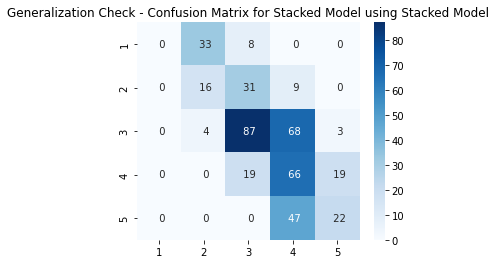

In [35]:
plot_conf_matrix(y_asia,gen_preds,unique_class_label, title="Generalization Check - Confusion Matrix for Stacked Model using Stacked Model")

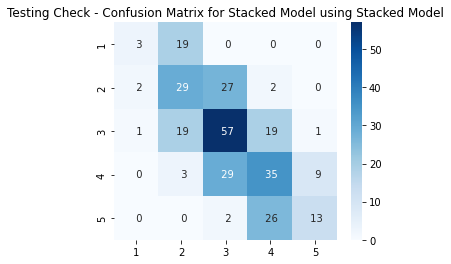

In [36]:
plot_conf_matrix(y_test,test_preds,unique_class_label, title="Testing Check - Confusion Matrix for Stacked Model using Stacked Model")